<hr style="border-color: black; border-style: groove;">
<center><h3> CS 452/552 Data Science with Python </h3></center>
<center><h3> Project 3 </h3></center>
<center><h3> Classification Challange - Credit Card Fraud Detection </h3></center>
<center><h3> Batuhan Erden </h3></center>
<hr style="border-color: black; border-style: groove;">

<h3> Imports </h3>

In [1]:
import random
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn import svm, linear_model, metrics, preprocessing, model_selection, neural_network

<h3> Global Constants </h3>

In [2]:
DATASET_PATH = "./"

<h3> Read dataset from csv </h3>

In [3]:
dataset = pd.read_csv(DATASET_PATH + "creditcard.csv")
dataset = dataset.rename(columns={"Class": "Fraud"})  # Rename feature 'Class' to 'Fraud'

dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Fraud
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<h3> Plot to see how unbalanced the data is </h3>

492 frauds out of 284807 transactions which is 0.1727% percent of all transactions..


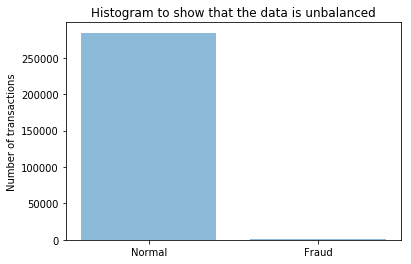

In [4]:
# Calculate
fraud_column_counts = dataset.Fraud.value_counts()

num_fraud = fraud_column_counts[1]
num_transactions = sum(fraud_column_counts)

print("{} frauds out of {} transactions which is {:.4f}% percent of all transactions..".
      format(num_fraud, num_transactions, num_fraud / num_transactions * 100))

# Plot
plt.title("Histogram to show that the data is unbalanced")
plt.ylabel('Number of transactions')

plt.xticks([0, 1], ["Normal", "Fraud"])
plt.bar([0, 1], [num_transactions - num_fraud, num_fraud], align="center", alpha=0.5)
 
plt.show()

<h3> Ignore features that have almost no effect on the frauds </h3>

In [5]:
mean_threshold = 0.6

v_features = dataset.iloc[:, 1:29].columns
v_features_to_drop = ["Time"]

for v_feature in v_features:
    mean_fraud = np.mean(dataset[v_feature][dataset["Fraud"] == 1])
    
    if -mean_threshold <= mean_fraud <= mean_threshold:
        v_features_to_drop.append(v_feature)

dataset = dataset.drop(v_features_to_drop, axis=1)

print("Features to be ignored: %a" % v_features_to_drop)
dataset.head()

Features to be ignored: ['Time', 'V8', 'V13', 'V15', 'V20', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Fraud
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,69.99,0


<h3> Normalize amounts </h3>

In [6]:
dataset["Amount"] = preprocessing.StandardScaler().fit_transform(dataset["Amount"].values.reshape(-1, 1))
dataset.iloc[:, dataset.columns == "Amount"].head()

,Amount
0,0.244964
1,-0.342475
2,1.160686
3,0.140534
4,-0.073403


<h3> Minimize and shuffle the dataset </h3>

In [7]:
safe_transactions = dataset[dataset["Fraud"] == 0]
fraudulent_transactions = dataset[dataset["Fraud"] == 1]

random_safe_transactions = safe_transactions.sample(n=len(fraudulent_transactions))

data_minimized = pd.concat(([fraudulent_transactions, random_safe_transactions]), axis=0)
data_minimized = data_minimized.sample(frac=1)  # Shuffle the dataset

print("# of Safe == # of Fraudulent? --> {}".format(len(data_minimized) / 2 == len(fraudulent_transactions)))
data_minimized.iloc[:, data_minimized.columns == "Fraud"].head()

# of Safe == # of Fraudulent? --> True


,Fraud
251891,1
153885,1
53591,1
192382,1
222984,0


<h3> Prepare inputs and labels </h3>

In [8]:
def get_inputs_and_labels(data):
    inputs = data.iloc[:, data.columns != "Fraud"]
    labels = data.iloc[:, data.columns == "Fraud"]

    inputs = np.array(inputs)
    labels = np.array(labels).flatten()
    
    return inputs, labels
    
X, y = get_inputs_and_labels(dataset)
X_minimized, y_minimized = get_inputs_and_labels(data_minimized)

<h3> Plot Precision-Recall Curve & Compute Confusion Matrix to check the accuracy of Minimized Data & Actual Data </h3>

In [9]:
def plot_precision_recall_curve(classifier, test, precision_score):
    # Average Precision
    average_precision = metrics.average_precision_score(test, precision_score)
    print("Average Precision-Recall Score (AUPRC): {:.2f}%".format(average_precision * 100))
    
    # Compute Precision-Recall Curve
    precision, recall, _ = metrics.precision_recall_curve(test, precision_score)
    
    # Plot Precision-Recall Curve
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.plot(recall, precision)
    plt.fill_between(recall, precision, alpha=0.2, color="green")
    plt.show()
    
def compute_confusion_matrix(classifier, test, predictions):
    np.set_printoptions(precision=4)
    confusion_matrix = metrics.confusion_matrix(test, predictions)
    
    # Print Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix)
    
    # Print Normalized Confusion Matrix
    confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    print("Normalized Confusion Matrix:")
    print(confusion_matrix_normalized)
    
    # Print the prediction accuracy of fraudulent transactions
    print("Prediction accuracy of fraudulent transactions (Recall Accuracy): {:.2f}%"
          .format(confusion_matrix_normalized[1, 1] * 100))

<li><h3> Accuracy of Minimized Data </h3></li>

------------------------------------------------------------------------------------------
Average Precision-Recall Score (AUPRC): 96.62%


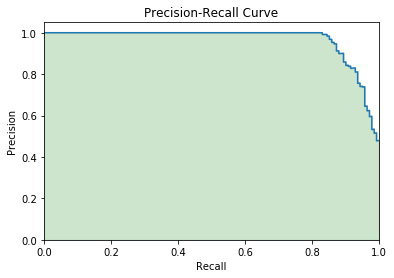

Confusion Matrix:
[[ 92  62]
 [  6 136]]
Normalized Confusion Matrix:
[[ 0.5974  0.4026]
 [ 0.0423  0.9577]]
Prediction accuracy of fraudulent transactions (Recall Accuracy): 95.77%
------------------------------------------------------------------------------------------


In [10]:
print("-" * 90)

X_minimized_train, X_minimized_test, y_minimized_train, y_minimized_test = model_selection.train_test_split(
    X_minimized, y_minimized, test_size=.3, random_state=0)

classifier = linear_model.LogisticRegression(C=.001, penalty="l1")

# Area Under the Precision-Recall Curve
classifier.fit(X_minimized_train, y_minimized_train)
precision_score = classifier.decision_function(X_minimized_test)
plot_precision_recall_curve(classifier, y_minimized_test, precision_score)

# Confusion Matrix
classifier.fit(X_minimized_train, y_minimized_train)
predictions = classifier.predict(X_minimized_test)
compute_confusion_matrix(classifier, y_minimized_test, predictions)

print("-" * 90)

<li><h3> Accuracy of Actual Data </h3></li>

------------------------------------------------------------------------------------------
Average Precision-Recall Score (AUPRC): 59.60%


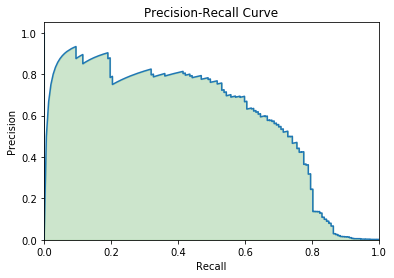

Confusion Matrix:
[[48947 36349]
 [    8   139]]
Normalized Confusion Matrix:
[[ 0.5738  0.4262]
 [ 0.0544  0.9456]]
Prediction accuracy of fraudulent transactions (Recall Accuracy): 94.56%
------------------------------------------------------------------------------------------


In [11]:
print("-" * 90)

X_minimized_train, _, y_minimized_train, _ = model_selection.train_test_split(
    X_minimized, y_minimized, test_size=.3, random_state=0)
_, X_test, _, y_test = model_selection.train_test_split(X, y, test_size=.3, random_state=0)

classifier = linear_model.LogisticRegression(C=.001, penalty="l1")

# Area Under the Precision-Recall Curve
classifier.fit(X_minimized_train, y_minimized_train)
precision_score = classifier.decision_function(X_test)
plot_precision_recall_curve(classifier, y_test, precision_score)

# Confusion Matrix
classifier.fit(X_minimized_train, y_minimized_train)
predictions = classifier.predict(X_test)
compute_confusion_matrix(classifier, y_test, predictions)

print("-" * 90)

<h3> Test the score of Minimized Data using LogisticRegression with 5-Fold Cross Validation and the AUPRC </h3>

In [12]:
classifier = linear_model.LogisticRegression(C=.001, penalty="l1")
n_splits = 5

kfold = model_selection.KFold(n_splits=n_splits, shuffle=False)
scores = [[], []]

print("-" * 60)
print("LogisticRegression with %d-Fold Cross Validation" % n_splits)
print("-" * 60)

for train_index, test_index in kfold.split(X_minimized):
    classifier.fit(X_minimized[train_index], y_minimized[train_index])
    decision = classifier.decision_function(X_minimized[test_index])
    
    score1 = metrics.roc_auc_score(y_minimized[test_index], decision)
    score2 = metrics.average_precision_score(y_minimized[test_index], decision)
    
    scores[0].append(score1)
    scores[1].append(score2)
    
    print("AUPRC found using the trapezoidal rule: {:.2f}%".format(score1 * 100))
    print("AUPRC found without using the trapezoidal rule: {:.2f}%".format(score2 * 100))

print("-" * 60)
print("Average AUPRC found using using the trapezoidal rule: {:.2f}%".format(np.mean(scores[0]) * 100))
print("Average AUPRC found using without using the trapezoidal rule: {:.2f}%".format(np.mean(scores[1]) * 100))
print("-" * 60)

------------------------------------------------------------
LogisticRegression with 5-Fold Cross Validation
------------------------------------------------------------
AUPRC found using the trapezoidal rule: 96.95%
AUPRC found without using the trapezoidal rule: 98.27%
AUPRC found using the trapezoidal rule: 94.30%
AUPRC found without using the trapezoidal rule: 95.94%
AUPRC found using the trapezoidal rule: 93.96%
AUPRC found without using the trapezoidal rule: 96.17%
AUPRC found using the trapezoidal rule: 94.40%
AUPRC found without using the trapezoidal rule: 96.33%
AUPRC found using the trapezoidal rule: 96.39%
AUPRC found without using the trapezoidal rule: 97.29%
------------------------------------------------------------
Average AUPRC found using using the trapezoidal rule: 95.20%
Average AUPRC found using without using the trapezoidal rule: 96.80%
------------------------------------------------------------


<center><h3 style="color: darkred"> Final Result </h3></center>
<center><h4> Average AUPRC (using the trapezoidal rule) < Average AUPRC (without using the trapezoidal rule) </h4></center>
<center><h4> 95.05% < 96.63% </h4></center>